In [189]:
import pandas as pd
import numpy as np 
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.ensemble import RandomForestClassifier


In [2]:
def getDfofAllExcel(osDir):
    dfDict = {}
    for fileName in os.listdir(osDir):
        dfName = re.sub(".xlxs\Z", "", fileName)
        dfDict[dfName] = pd.read_excel(osDir+"/"+fileName)
    return dfDict 

ext_dfs = getDfofAllExcel("2024 MB Hackathon Materials/Prompt 2 Data - Fan Archetype")

print(ext_dfs.keys())

dict_keys(['PrimaryTix.xlsx', 'Survey.xlsx', 'SecondaryTix.xlsx'])


In [3]:
ext_dfs['PrimaryTix.xlsx']

,CustomerID,Zip,ProductType,Revenue,ScanRate,NumGames
0,3503,53150,Groups,330.0,0.000000,2
1,3503,53150,Partial Plan,1860.0,0.400000,10
2,3503,53150,Single Game,832.0,1.000000,3
3,984,53219,Full Season,43842.0,0.069767,43
4,3272,53214-5403,Full Season,1500.0,0.093023,43
...,...,...,...,...,...,...
2773,217,530869642,Groups,568.0,0.750000,1
2774,538,53188,Full Season,72000.0,0.145349,43
2775,538,53188,Groups,500.0,1.000000,1
2776,633,53151,Single Game,348.0,0.666667,2


In [4]:
#Iterativly Impute For each Df
def impute_dfs(dict_dfs):
    imputed_dfs = {}
    imputer_dict = {}

    for df_key in ext_dfs.keys():
        #drop unimportant columns
        df_to_impute = ext_dfs[df_key].drop(columns = ['Zip'])
        imputer = IterativeImputer()
        #Save trained imputer and imputed data in seperate dictionaries
        imputer_dict[df_key] = imputer.fit(df_to_impute)
        imputed_file = imputer.transform(df_to_impute)
        imputed_dfs[df_key] = pd.DataFrame(imputed_file)
    
    return imputed_dfs, imputer_dict

In [5]:
ext_dfs['Survey.xlsx']['NPS']

0       Promoter
1       Promoter
2       Promoter
3       Promoter
4       Promoter
          ...   
6206    Promoter
6207    Promoter
6208    Promoter
6209    Promoter
6210    Promoter
Name: NPS, Length: 6211, dtype: object

In [6]:
#Get char2idx and idx2char dicts so we can impute data later
def transform_char2idx(df):

    df = set(df)
    char2idx = {u:i for i, u in enumerate(df)}
    idx2char = np.array(df)
    
    return char2idx, idx2char

#Get zip code char2idx
zip_df = pd.concat([ext_dfs['PrimaryTix.xlsx']['Zip'], ext_dfs['SecondaryTix.xlsx']['Zip']])
char2idx_zip, idx2char_zip = transform_char2idx(zip_df)

#Get survey columns char2idx(except ratings)
survey_non_satisfy_columns = [
    'NPS',
    'Game',
    'FanArchetype',
    'Travel',
    'PurchasedF&B',
    'UsedSelfCheckoutStand', 
    'UsedLyft',
    'Membership'
    ]

survey_satisfy_columns = [
    'Parking',
    'Deer District',
    'Security',
    'TicketScanning',
    'Ushers',
    'BuildingCleanliness',
    'Retail',
    'FoodAndBeverage',
    'Technology',
    'InGameEntertainment',
    'InSeatExperience',
    'OverallValue',
    'OverallArenaExperience',
    'BeverageValue',
    'FoodValue',
    'SelfCheckoutStandSatisfaction'
]

char2idx_dict = {}
idx2char_dict = {}
for col in survey_non_satisfy_columns:
    char2idx_dict[col], idx2char_dict[col] = transform_char2idx(ext_dfs['Survey.xlsx'][col])


#Ratings char2idx 
ratings2idx = {
'Extremely dissatisfied': 1, 
'Somewhat dissatisfied': 2, 
'Neither satisfied nor dissatisfied': 3, 
'Somewhat satisfied': 4, 
'Extremely satisfied': 5}

idx2ratings = [
    'Extremely dissatisfied', 
    'Somewhat dissatisfied',
    'Neither satisfied nor dissatisfied',
    'Somewhat satisfied',
    'Extremely satisfied'
]


In [7]:
#Convert data to number Ids
survey_df = ext_dfs['Survey.xlsx']

#replace items in none satisfaction columns
for col in survey_non_satisfy_columns:
    survey_df[col] = survey_df[col].replace(char2idx_dict[col])

#replace items in satisfaction columns 
for col in survey_satisfy_columns:
    survey_df[col] = survey_df[col].replace(ratings2idx)

survey_df.head()

,NPS,NPS Score,Game,CustomerID,FanArchetype,NumTix,Revenue,Parking,Deer District,Security,...,OverallValue,OverallArenaExperience,Travel,PurchasedF&B,BeverageValue,FoodValue,UsedSelfCheckoutStand,SelfCheckoutStandSatisfaction,UsedLyft,Membership
0,0,10,1,3503,2,2,294.0,4.0,NaN,5.0,...,4.0,5.0,0,4,2.0,2.0,0.0,NaN,0.0,1
1,0,10,10,1250,0,3,846.0,NaN,5.0,5.0,...,5.0,5.0,8,4,5.0,5.0,0.0,NaN,0.0,1
2,0,9,2,984,1,4,684.0,5.0,5.0,5.0,...,5.0,5.0,0,4,5.0,5.0,0.0,NaN,0.0,0
3,0,10,12,984,1,1,171.0,4.0,4.0,4.0,...,5.0,5.0,0,4,5.0,4.0,0.0,NaN,0.0,0
4,0,10,22,984,1,1,171.0,NaN,1.0,5.0,...,5.0,5.0,8,4,5.0,5.0,0.0,NaN,2.0,0


In [126]:
survey_df_columns = survey_df.columns
survey_np = survey_df.to_numpy()

#impute data
imputer = IterativeImputer(random_state=0)
imputated_values = imputer.fit_transform(survey_np)

print(f'Before Imputation: {survey_np[5][:]}')
print(f'After Imputation: {imputated_values[5][:]}')

Before Imputation: [1.000e+00 8.000e+00 9.000e+00 3.272e+03 6.000e+00 2.000e+00 3.600e+01
       nan       nan 4.000e+00 5.000e+00 3.000e+00 4.000e+00       nan
 4.000e+00 3.000e+00 4.000e+00 4.000e+00 4.000e+00 5.000e+00 6.000e+00
 3.000e+00       nan       nan 2.000e+00       nan 0.000e+00 1.000e+00]
After Imputation: [1.00000000e+00 8.00000000e+00 9.00000000e+00 3.27200000e+03
 6.00000000e+00 2.00000000e+00 3.60000000e+01 3.32240016e+00
 3.91503217e+00 4.00000000e+00 5.00000000e+00 3.00000000e+00
 4.00000000e+00 3.72133689e+00 4.00000000e+00 3.00000000e+00
 4.00000000e+00 4.00000000e+00 4.00000000e+00 5.00000000e+00
 6.00000000e+00 3.00000000e+00 3.13231829e+00 3.23777464e+00
 2.00000000e+00 4.49792628e+00 0.00000000e+00 1.00000000e+00]


In [ ]:
#For imputed data round to get classifications instead of regression



In [53]:
#Define Autoencoder

input_layer = Input(shape = (28,))
encoder_1 = Dense(units = 256, activation = 'relu')(input_layer)
encoder_2 = Dense(units = 128, activation = 'relu')(encoder_1)
encoder_3 = Dense(units = 64, activation = 'relu')(encoder_2)
encoder_4 = Dense(units = 32, activation = 'relu')(encoder_3)
encoder_5 = Dense(units = 16, activation = 'relu')(encoder_4)
latent_layer = Dense(units = 2, activation = 'relu')(encoder_2)
decoder_1 = Dense(units = 16, activation = 'relu')(latent_layer)
decoder_2 = Dense(units = 32, activation = 'relu')(decoder_1)
decoder_3 = Dense(units = 64, activation = 'relu')(decoder_2)
decoder_4 = Dense(units = 128, activation = 'relu')(decoder_3)
output_data = Dense(units = 28, activation = 'linear')(decoder_4)

imputed_autoencoder = Model(inputs = input_layer, outputs = output_data)
nonimputated_autoencoder = Model(inputs = input_layer, outputs = output_data)

#Compile AutoEncoder
optimizer = keras.optimizers.legacy.Adam(0.0001)
loss = keras.losses.MeanSquaredError()

imputed_autoencoder.compile(optimizer = optimizer, loss = loss)
nonimputated_autoencoder.compile(optimizer = keras.optimizers.legacy.Adam(0.001), loss = loss)

## Model using Non-Imputated Data

In [85]:
#Create copy for nonimputated model data
nonimputated_survey_df = ext_dfs['Survey.xlsx'].fillna(-1)
nonimputated_survey_np = nonimputed_survey_df.to_numpy()

In [ ]:
#Set checkpoint to save best model 
nonimputed_callback = tf.keras.callbacks.ModelCheckpoint(filepath = 'nonimputated_model(2-18).h5',
                                                         monitor = 'loss',
                                                         save_best_only = True,
                                                         mode = 'min',  # or 'max' depending on the metric being monitored
                                                         verbose = 1)
#fit autoencoder
nonimputated_autoencoder.fit(nonimputated_survey_np, nonimputated_survey_np, epochs = 30, callbacks = [nonimputed_callback])

In [46]:
#load best autoencoder
best_nonimputated_autoencoder = tf.keras.models.load_model('Best Models/best_nonimputated_model(2-18).h5')

best_nonimputated_autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_22 (Dense)            (None, 256)               7424      
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 2)                 258       
                                                                 
 dense_28 (Dense)            (None, 16)                48        
                                                                 
 dense_29 (Dense)            (None, 32)                544       
                                                                 
 dense_30 (Dense)            (None, 64)                2112

In [48]:
#create dim reduction model out of autoencoder
nonimputated_dim_reduce_model = Model(inputs = best_nonimputated_autoencoder.input, outputs=best_nonimputated_autoencoder.get_layer('dense_27').output)

#summary of dim reduction model
nonimputated_dim_reduce_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_22 (Dense)            (None, 256)               7424      
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 2)                 258       
                                                                 
Total params: 40578 (158.51 KB)
Trainable params: 40578 (158.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
nonimputated_dim_reduce_values = nonimputated_dim_reduce_model.predict(nonimputed_survey_np)

kmeans = KMeans(n_clusters=7, n_init = 10)
kmeans.fit(nonimputated_dim_reduce_values)
nonimputated_centroids = kmeans.cluster_centers_
nonimputated_labels = kmeans.labels_

195/195 [==============================] - 0s 497us/step


#### End of non imputated Model

## Model Using Imputated Data

In [54]:
#Set checkpoint to save best model 
imputed_callback = tf.keras.callbacks.ModelCheckpoint(filepath='imputated_model(2-18).h5',
                                                         monitor='loss',
                                                         save_best_only=True,
                                                         mode='min',  # or 'max' depending on the metric being monitored
                                                         verbose=1)
#fit autoencoder
imputed_autoencoder.fit(imputated_values, imputated_values, epochs = 100, callbacks = [imputed_callback])

Epoch 1/100
171/195 [=========================>....] - ETA: 0s - loss: 139326.6719
Epoch 1: loss improved from inf to 123652.98438, saving model to imputated_model().h5
195/195 [==============================] - 1s 1ms/step - loss: 123652.9844
Epoch 2/100
181/195 [==========================>...] - ETA: 0s - loss: 8012.9663
Epoch 2: loss improved from 123652.98438 to 8568.05566, saving model to imputated_model().h5
195/195 [==============================] - 0s 2ms/step - loss: 8568.0557
Epoch 3/100
183/195 [===========================>..] - ETA: 0s - loss: 8526.9121
Epoch 3: loss improved from 8568.05566 to 8234.94336, saving model to imputated_model().h5
195/195 [==============================] - 0s 1ms/step - loss: 8234.9434
Epoch 4/100
161/195 [=======================>......] - ETA: 0s - loss: 7435.7905
Epoch 4: loss improved from 8234.94336 to 7598.89209, saving model to imputated_model().h5
195/195 [==============================] - 0s 1ms/step - loss: 7598.8921
Epoch 5/100
186/195

In [66]:
#load best autoencoder
best_imputated_autoencoder = tf.keras.models.load_model('Best Models/best_imputated_model(2-18).h5')

best_imputated_autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_44 (Dense)            (None, 256)               7424      
                                                                 
 dense_45 (Dense)            (None, 128)               32896     
                                                                 
 dense_49 (Dense)            (None, 2)                 258       
                                                                 
 dense_50 (Dense)            (None, 16)                48        
                                                                 
 dense_51 (Dense)            (None, 32)                544       
                                                                 
 dense_52 (Dense)            (None, 64)                211

In [67]:
#create dim reduction model out of autoencoder
imputated_dim_reduce_model = Model(inputs = best_imputated_autoencoder.input, outputs=best_imputated_autoencoder.get_layer('dense_49').output)

#summary of dim reduction model
imputated_dim_reduce_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_44 (Dense)            (None, 256)               7424      
                                                                 
 dense_45 (Dense)            (None, 128)               32896     
                                                                 
 dense_49 (Dense)            (None, 2)                 258       
                                                                 
Total params: 40578 (158.51 KB)
Trainable params: 40578 (158.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
imputated_reduced_dim_values = imputated_dim_reduce_model.predict(imputed_values)

kmeans = KMeans(n_clusters=7, n_init = 10)
kmeans.fit(imputated_reduced_dim_values)
imputated_centroids = kmeans.cluster_centers_
imputated_labels = kmeans.labels_

195/195 [==============================] - 0s 623us/step


## Plot both imputated and nonimputated data

In [205]:
def plot_vernoli_data(xy, centroids, classifications, kmeans_labels, data_classify, savefig = False):
    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # First subplot
    # Plot the data points k-means based on centroid
    axs[0].scatter(xy[:, 0], xy[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5, label='Data points')

    # Plot the centroids
    axs[0].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, color='red', label='Centroids')

    # Create Voronoi diagram
    vor = Voronoi(centroids)

    # Plot Voronoi cells
    voronoi_plot_2d(vor, ax=axs[0], show_vertices=False, line_colors='black', line_width=1, line_alpha=0.5)

    # Add legend
    axs[0].legend()

    # Add labels and title
    axs[0].set_xlabel('Feature 1')
    axs[0].set_ylabel('Feature 2')
    axs[0].set_title(f'K-means Clustering (colored by kmeans)[{data_classify}]')

    # Second subplot
    # Plot with colors as their archetypes
    axs[1].scatter(xy[:, 0], xy[:, 1], c=classifications, cmap='viridis', alpha=0.5, label='Data points')

    # Plot the centroids
    axs[1].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, color='red', label='Centroids')

    # Create Voronoi diagram
    vor = Voronoi(centroids)

    # Plot Voronoi cells
    voronoi_plot_2d(vor, ax=axs[1], show_vertices=False, line_colors='black', line_width=1, line_alpha=0.5)
    
    # Add legend
    axs[1].legend()

    # Add labels and title
    axs[1].set_xlabel('Feature 1')
    axs[1].set_ylabel('Feature 2')
    axs[1].set_title(f'K-means Clustering (colored by archetype)[{data_classify}]')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    if savefig == True:
        plt.savefig(f'{data_classify}.png')
        
    # Show the plots
    plt.show()


In [206]:
classifications = ext_dfs['Survey.xlsx']['FanArchetype']

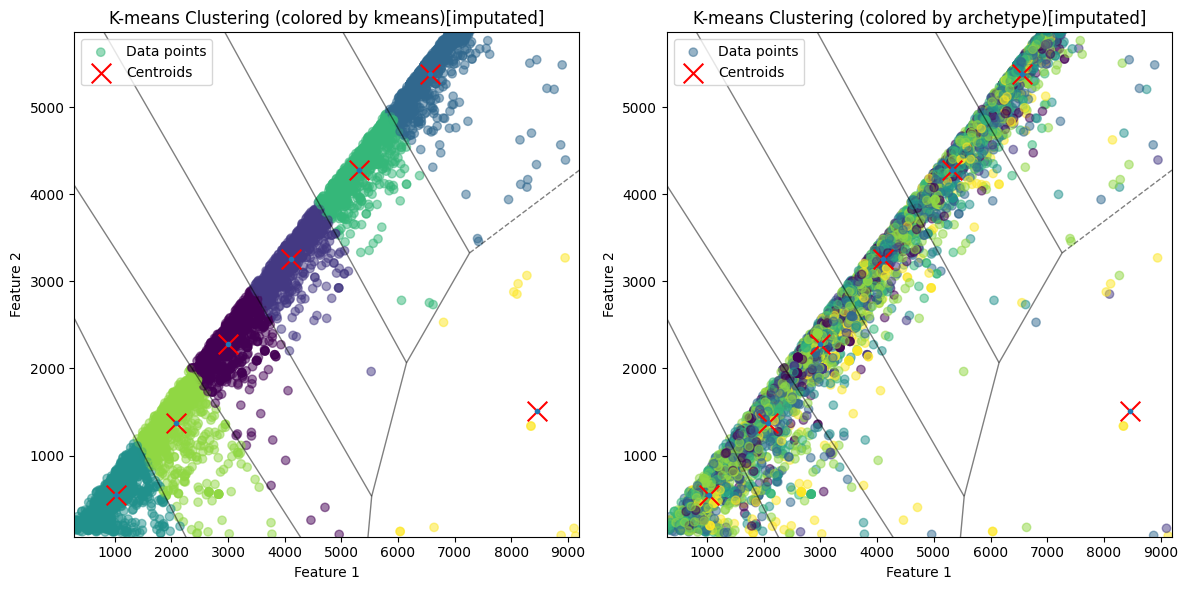

In [207]:
#imputated data
plot_vernoli_data(imputated_reduced_dim_values, imputated_centroids, classifications, imputated_labels, 'imputated', savefig=True)

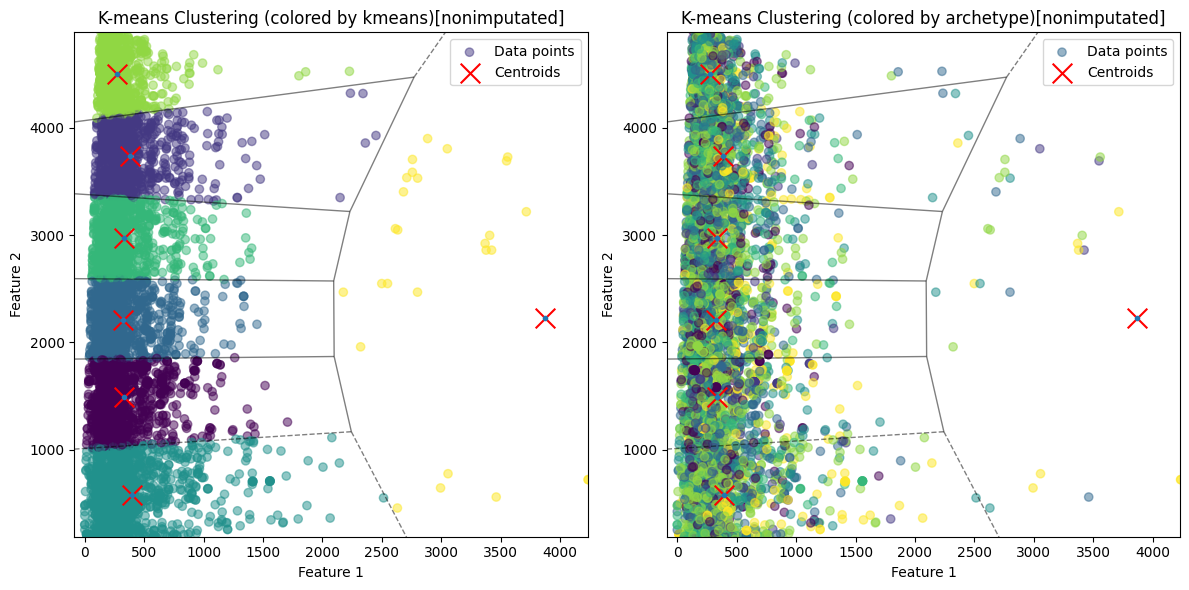

In [208]:
#plot each dot color codded to their archetype
plot_vernoli_data(nonimputated_dim_reduce_values, nonimputated_centroids, classifications, nonimputated_labels, 'nonimputated')

In [215]:
#Create Neural network for archetype prediciton

fan_archetype_model = Sequential([
    Input(shape = (27,)),
    Dense(units = 256, activation = 'relu'),
    Dense(units = 128, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(units = 32, activation = 'relu'),
    Dense(units = 16, activation = 'relu'),
    Dense(units = 7, activation = 'softmax')
])

imputed_pred_model = fan_archetype_model
nonimputed_pred_model = fan_archetype_model

optimizer = keras.optimizers.legacy.Adam(0.0001)
loss = keras.losses.SparseCategoricalCrossentropy()

imputed_pred_model.compile(optimizer = optimizer, loss = loss)
nonimputed_pred_model.compile(optimizer = optimizer, loss = loss)

In [230]:
#Define X and Y data non imputated data
X = ext_dfs['Survey.xlsx'].drop(columns = ['FanArchetype']).fillna(-1).to_numpy()
Y = ext_dfs['Survey.xlsx']['FanArchetype'].fillna(-1).to_numpy()

Xtrain_imp, Xtest_imp, Ytrain_imp, Ytest_imp = train_test_split(X, Y, test_size = .1)
Xtrain_imp, Xval_imp, Ytrain_imp, Yval_imp = train_test_split(Xtrain_imp, Ytrain_imp, test_size = .1)

#Define X and Y data imputated data
#Drop fan archetype columns
X = np.delete(imputated_values, 4, axis = 1)
#Extract column of Fan Archetypes 
Y = imputated_values[:,4]

Xtrain_nonimp, Xtest_nonimp, Ytrain_nonimp, Ytest_nonimp = train_test_split(X, Y, test_size = .1)
Xtrain_nonimp, Xval_nonimp, Ytrain_nonimp, Yval_nonimp = train_test_split(Xtrain_nonimp, Ytrain_nonimp, test_size = .1)

In [242]:
#Train imputed Model
imputed_pred_model.fit(Xtrain_imp, Ytrain_imp, epochs = 100)

Epoch 1/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7904
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7799
Epoch 3/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7750
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 1.7747
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7714
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7752
Epoch 7/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7698
Epoch 8/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7703
Epoch 9/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7677
Epoch 10/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7717
Epoch 11/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7687
Epoch 12/100
158/158 [==============================] - 0s 1ms/step - loss: 1.7670
Epoch 13/100


In [241]:
#get predicted values from softmax
imp_train_results = imputed_pred_model.predict(Xtrain_imp)
imp_train_predictions = np.argmax(imp_train_results, axis = 1)

imp_test_results = imputed_pred_model.predict(Xtest_imp)
imp_test_predictions = np.argmax(imp_test_results, axis = 1)

#Check model  accuracy 
model_train_acc = accuracy_score(imp_train_predictions, Ytrain_nonimp)
model_test_acc = accuracy_score(imp_test_predictions, Ytest_imp)

print(f'Model Train Accuracy: {model_train_acc}')
print(f'Model Test Accuracy: {model_test_acc}')

20/20 [==============================] - 0s 598us/step
Model Train Accuracy: 0.2481113320079523
Model Test Accuracy: 0.26366559485530544


### Train nonimputed model on Fan Archetype Prediction

In [235]:
#Train imputed Model
nonimputed_pred_model.fit(Xtrain_nonimp, Ytrain_nonimp, epochs = 100)

Epoch 1/100
158/158 [==============================] - 0s 1ms/step - loss: 1.8412
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 1.8274
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 1.8153
Epoch 4/100
158/158 [==============================] - 0s 3ms/step - loss: 1.8100
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 1.8119
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 1.8182
Epoch 7/100
158/158 [==============================] - 0s 1ms/step - loss: 1.8061
Epoch 8/100
158/158 [==============================] - 0s 1ms/step - loss: 1.8056
Epoch 9/100
158/158 [==============================] - 0s 1ms/step - loss: 1.8043
Epoch 10/100
158/158 [==============================] - 0s 1ms/step - loss: 1.8016
Epoch 11/100
158/158 [==============================] - 0s 1ms/step - loss: 1.8058
Epoch 12/100
158/158 [==============================] - 0s 1ms/step - loss: 1.8122
Epoch 13/100


In [240]:
#get predicted values from softmax
nonimp_train_results = nonimputed_pred_model.predict(Xtrain_nonimp)
nonimp_train_predictions = np.argmax(nonimp_train_results, axis = 1)

nonimp_test_results = nonimputed_pred_model.predict(Xtest_nonimp)
nonimp_test_predictions = np.argmax(nonimp_test_results, axis = 1)

#Check model  accuracy 
model_train_acc = accuracy_score(nonimp_train_predictions, Ytrain_nonimp)
model_test_acc = accuracy_score(nonimp_test_predictions, Ytest_nonimp)

print(f'Model Train Accuracy: {model_train_acc}')
print(f'Model Test Accuracy: {model_test_acc}')

20/20 [==============================] - 0s 667us/step
Model Train Accuracy: 0.2906560636182903
Model Test Accuracy: 0.27491961414790994


In [204]:
#Random forrest classifier
rf_classifier = RandomForestClassifier(n_estimators = 600)
rf_classifier.fit(Xtrain_imp, Ytrain_imp)

forest_pred_test = rf_classifier.predict(Xtest_imp)
test_accuracy = accuracy_score(forest_pred_test, Ytest_imp)

forest_pred_train = rf_classifier.predict(Xtrain_imp)
train_accuracy = accuracy_score(forest_pred_train, Ytrain_imp)

print(f'Random Forrest Test Acc: {test_accuracy}')
print(f'Random Forrest Train Acc: {train_accuracy}')

Random Forrest Test Acc: 0.3837489943684634
Random Forrest Train Acc: 1.0


In [227]:
#Train Neural network on K-means classifiers
X = ext_dfs['Survey.xlsx'].drop(columns = ['FanArchetype']).fillna(-1).to_numpy()
Y = imputated_labels

Xtrain_k, Xtest_k, Ytrain_k, Ytest_k = train_test_split(X, Y, test_size = .2)

kmeans_pred_model = fan_archetype_model

optimizer = keras.optimizers.legacy.Adam(0.0001)
loss = keras.losses.SparseCategoricalCrossentropy()

kmeans_pred_model.compile(optimizer = optimizer, loss = loss)

In [244]:
kmeans_pred_model.fit(Xtrain_k, Ytrain_k, epochs = 200)

Epoch 1/200
156/156 [==============================] - 0s 1ms/step - loss: 1.5479
Epoch 2/200
156/156 [==============================] - 0s 1ms/step - loss: 1.1729
Epoch 3/200
156/156 [==============================] - 0s 1ms/step - loss: 1.0464
Epoch 4/200
156/156 [==============================] - 0s 1ms/step - loss: 0.9602
Epoch 5/200
156/156 [==============================] - 0s 1ms/step - loss: 0.9279
Epoch 6/200
156/156 [==============================] - 0s 3ms/step - loss: 0.8771
Epoch 7/200
156/156 [==============================] - 0s 2ms/step - loss: 0.8516
Epoch 8/200
156/156 [==============================] - 0s 1ms/step - loss: 0.8345
Epoch 9/200
156/156 [==============================] - 0s 1ms/step - loss: 0.8373
Epoch 10/200
156/156 [==============================] - 0s 1ms/step - loss: 0.8076
Epoch 11/200
156/156 [==============================] - 0s 1ms/step - loss: 0.8014
Epoch 12/200
156/156 [==============================] - 0s 1ms/step - loss: 0.7916
Epoch 13/200


In [252]:
#get predicted values from softmax
k_train_results = kmeans_pred_model.predict(Xtrain_k)
k_train_predictions = np.argmax(k_train_results, axis = 1)

k_test_results = kmeans_pred_model.predict(Xtest_k)
k_test_predictions = np.argmax(k_test_results, axis = 1)

#Check model  accuracy 
model_train_acc = accuracy_score(k_train_predictions, Ytrain_k)
model_test_acc = accuracy_score(k_test_predictions, Ytest_k)

print(f'Model Train Accuracy: {model_train_acc}')
print(f'Model Test Accuracy: {model_test_acc}')

39/39 [==============================] - 0s 592us/step
Model Train Accuracy: 0.9126409017713365
Model Test Accuracy: 0.8930008045052292


In [253]:
#Save and load best model
kmeans_pred_model.save('<placeholder')
kmeans = tf.keras.models.load_model('<placeholder')


INFO:tensorflow:Assets written to: Best Models/best kmeans(2-18)/assets


INFO:tensorflow:Assets written to: Best Models/best kmeans(2-18)/assets


39/39 [==============================] - 0s 619us/step
Model Train Accuracy: 0.9126409017713365
Model Test Accuracy: 0.8930008045052292


array([0.05980169, 0.00902063, 0.05705108, 0.17015833, 0.01565596,
       0.30078885, 0.38752347], dtype=float32)